## Matching Intersections

Objective: if one rides across a street that has cicleway, even if he doesn't use it, we consider that he is using it :)

To do so, we establish a bigger buffer size for the way (bikeway, street).

### Bikeways

In [1]:
import geopandas as gpd
import folium
import glob
import os
import shapely
import pandas as pd
from matplotlib import pyplot as plt
import traceback as tb

from bikescience import intersect_ways as iw
from bikescience import sp_grid as gr

trip_buffer = '0001'
trip_buffer_n = 0.0001
way_buffer = '00035'
way_buffer_n = 0.00035

base_folder = '/home/ederson/geometry-buffers/'

In [ ]:
bikeway_classes = \
        gpd.read_file('../../data/sao-paulo/geosampa/SIRGAS_SHP_redecicloviaria/SIRGAS_SHP_redecicloviaria.shp')
bikeway_classes.crs = {'init': 'epsg:31983'}
bikeway_classes.to_crs({'init': 'epsg:4326'}, inplace=True)
bikeway_classes.head()

In [ ]:
bikeways = gpd.GeoDataFrame(data=bikeway_classes.rc_id, geometry=bikeway_classes.buffer(way_buffer_n))

In [ ]:
bikeway_id = ['rc_id']
trip_id = ['tripid']
csv_folder = base_folder + 'matching4/'

In [ ]:
for f in glob.glob(base_folder + 'trips-' + trip_buffer + '-*.geojson'):
    print(f)
    file = os.path.split(f)[1].replace('.geojson', '').replace('-0001', '')
    csv = csv_folder + file + '.csv'
    if os.path.exists(csv):
        print('--- already processed')
        continue
    trips = gpd.read_file(f)
    intersections = iw.intersect_ways(bikeways, bikeway_id, trips, trip_id)
    intersections['intersection_area'] = iw.metric_intersection_area(intersections)
    intersections['bikeway_area_perc'] = intersections.intersection_area / \
                                         gpd.GeoSeries(intersections.geometry1).area
    intersections['trip_area_perc'] = intersections.intersection_area / \
                                      gpd.GeoSeries(intersections.geometry2).area
    intersections.drop(columns=['intersection', 'geometry1', 'geometry2'], inplace=True)
    intersections.to_csv(csv, index=False)

### Street classification

In [2]:
street_classification = gpd.read_file(
        '../../data/sao-paulo/geosampa/SIRGAS_SHP_classeviariacet/SIRGAS_SHP_classeviariacet_line.shp')
street_classification.cvc_dctipo.value_counts()

Local                153186
Coletora              49252
Arterial              24345
vtr                     783
Rodovia                 613
Vias de pedestres       339
Name: cvc_dctipo, dtype: int64

In [3]:
street_buffers = gpd.read_file(base_folder + 'street-classification-' + way_buffer + '.geojson')
street_buffers.head()

cvc_id                                           geometry
0       1  POLYGON ((-46.75507041663895 -23.7493292426853...
1       2  POLYGON ((-46.36631055919488 -23.5055802123650...
2       3  POLYGON ((-46.47594781948683 -23.5574980371042...
3       4  POLYGON ((-46.67502219895616 -23.7693905367893...
4       5  POLYGON ((-46.56031152678403 -23.5909626950299...

In [4]:
street_merge = gpd.GeoDataFrame(street_classification[['cvc_id', 'cvc_dctipo']].merge(street_buffers, on='cvc_id'))
street_merge.head()

cvc_id cvc_dctipo                                           geometry
0       1      Local  POLYGON ((-46.75507041663895 -23.7493292426853...
1       2   Coletora  POLYGON ((-46.36631055919488 -23.5055802123650...
2       3      Local  POLYGON ((-46.47594781948683 -23.5574980371042...
3       4      Local  POLYGON ((-46.67502219895616 -23.7693905367893...
4       5      Local  POLYGON ((-46.56031152678403 -23.5909626950299...

In [5]:
street_id = ['cvc_id']
trip_id = ['tripid']
csv_folder = base_folder + 'matching5/'

#### Eliminating overlays (they're many!!)

Priority:
1. Arterial
2. Coletora
3. Local

Algorithm for in-type overlay removing

In [6]:
from shapely.geometry import Polygon

polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),
                        Polygon([(1,1), (3,1), (3,3), (1,3)])])
df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})
df1.plot(color='red');

In [7]:
def remove_overlappings_internally(geodf, row_id, preserve_columns=[]):
    intersections = gpd.overlay(geodf, geodf, how='intersection')
    unique = {'intersection_id': [], row_id: [], 'geometry': []}
    
    for c in preserve_columns:
        unique[c] = []
        
    for idx, row in intersections.iterrows():
        id1 = row[row_id + '_1']
        id2 = row[row_id + '_2']
        if id1 == id2: 
            continue
        the_id = (min(id1, id2), max(id1, id2)) # intersections (1, 2) and (2, 1) are the same
        if the_id in unique['intersection_id']: continue
        unique['intersection_id'].append(the_id)
        for c in preserve_columns:
            unique[c].append(row[c + '_1'])
        unique[row_id].append(id1)
        unique['geometry'].append(row.geometry)
    
    del unique['intersection_id']
    unique_intersections = gpd.GeoDataFrame(unique)

    if len(unique_intersections) == 0: 
        return geodf
    
    # ERROR HERE - see overlappinig.txt
    differences = gpd.overlay(geodf, unique_intersections, how='difference')
    all_parts = gpd.GeoDataFrame(pd.concat([differences, unique_intersections]), crs={'init': 'epsg:4326'})
    dissolved = all_parts.dissolve(by=[row_id] + preserve_columns, as_index=False)
    return dissolved
    
flatten = remove_overlappings_internally(df1, row_id='df1')
display(flatten)
ax = flatten.plot(cmap='tab10')
flatten.plot(ax=ax, facecolor='none', edgecolor='k')

df1                                       geometry
0    1  POLYGON ((0 0, 0 2, 1 2, 1 1, 2 1, 2 0, 0 0))
1    2  POLYGON ((1 1, 1 2, 1 3, 3 3, 3 1, 2 1, 1 1))

Testing with real street data subset

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



cvc_id cvc_dctipo                                           geometry
0       35   Arterial  POLYGON ((-46.68524797050678 -23.5794940930963...
1       37   Arterial  POLYGON ((-46.69282329338414 -23.6327401923197...
2       47   Arterial  POLYGON ((-46.61366269222381 -23.6248526336247...
3       60   Arterial  POLYGON ((-46.46156527153717 -23.5403445615867...
4       63   Arterial  POLYGON ((-46.59441824612374 -23.5881803005969...
5       69   Arterial  POLYGON ((-46.69661554915498 -23.6195089951317...
6      108   Arterial  POLYGON ((-46.56379342863644 -23.5824947858537...
7      125   Arterial  POLYGON ((-46.77944998306714 -23.6615389686098...
8      127   Arterial  POLYGON ((-46.69643947340096 -23.6884458567646...
9      147   Arterial  POLYGON ((-46.59759332736168 -23.4573674858041...
10     153   Arterial  POLYGON ((-46.74766784494811 -23.6014625279391...
11     167   Arterial  POLYGON ((-46.52740404635799 -23.5313159772835...
12     203   Arterial  POLYGON ((-46.62808269108464 -23.6223247944752...
13     215   Arterial  POLYGON ((-46.58815324382347 -23.5414931340526...
14     229   Arterial  POLYGON ((-46.62814228728152 -23.6208864173391...
15     234   Arterial  POLYGON ((-46.65234637285337 -23.6825542651209...
16     237   Arterial  POLYGON ((-46.63683632003457 -23.6674694759034...
17     238   Arterial  POLYGON ((-46.60183427167181 -23.4828096749366...
18     245   Arterial  POLYGON ((-46.66626546240411 -23.694208279654,...
19    1257   Arterial  POLYGON ((-46.6607521556242 -23.60140581222414...

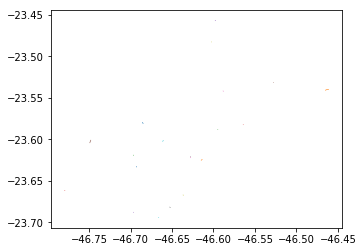

In [8]:
arterial_test = street_merge[street_merge.cvc_dctipo == 'Arterial'][:20]
flatten = remove_overlappings_internally(arterial_test, row_id='cvc_id', preserve_columns=['cvc_dctipo'])
display(flatten)
flatten.plot(cmap='tab10')

In [33]:
output = open(base_folder + 'overlapping.txt', 'w')

In [ ]:

output.write('---\n')
output.flush()
try:
    arterial = street_merge[street_merge.cvc_dctipo == 'Arterial']
    arterial = remove_overlappings_internally(arterial, row_id='cvc_id', preserve_columns=['cvc_dctipo'])
    output.write('Removed overlappings from Arterial\n')
    output.flush()
except:
    output.write(tb.format_exc())
output.flush()

In [ ]:
2+2

We can now prioritize by type
* difference overlays separate them
* the function defined above remove in-type overlappings

In [ ]:
output = open(base_folder + 'overlapping.txt', 'w')

try:
    """
    arterial = street_merge[street_merge.cvc_dctipo == 'Arterial']
    arterial = remove_overlappings_internally(arterial, row_id='cvc_id', preserve_columns=['cvc_dctipo'])
    output.write('Removed overlappings from Arterial\n')
    output.flush()
    """
    
    remaining = street_merge[street_merge.cvc_dctipo != 'Arterial']
    non_arterial = gpd.overlay(remaining, arterial, how='difference')
    output.write('Separated non-Arterial street segments\n')
    output.flush()

    coletora = non_arterial[non_arterial.cvc_dctipo == 'Coletora']
    coletora = remove_overlappings_internally(coletora, row_id='cvc_id', preserve_columns=['cvc_dctipo'])
    output.write('Removed overlappings from Coletora\n')
    output.flush()
    
    remaining = non_arterial[non_arterial.cvc_dctipo != 'Coletora']
    non_coletora = gpd.overlay(remaining, coletora, how='difference')
    output.write('Separated non-Coletora street segments\n')
    output.flush()

    local = non_coletora[non_coletora.cvc_dctipo == 'Local']
    remaining = non_coletora[non_coletora.cvc_dctipo != 'Local']

    # some cleaning is needed here
    local_multipolygons = local.apply(
            lambda row: type(row.geometry) == shapely.geometry.multipolygon.MultiPolygon, axis=1)
    local = local[~local_multipolygons]
    output.write('Filtered Local multipolygons\n')
    output.flush()
    
    remaining_multipolygons = remaining.apply(
            lambda row: type(row.geometry) == shapely.geometry.multipolygon.MultiPolygon, axis=1)
    remaining = remaining[~remaining_multipolygons]
    output.write('Filtered non-Local multipolygons\n')
    output.flush()
    # cleaning done.

    local = remove_overlappings_internally(local, row_id='cvc_id', preserve_columns=['cvc_dctipo'])
    output.write('Removed overlappings from Local\n')
    output.flush()

    other = gpd.overlay(remaining, local, how='difference')
    output.write('Separated non-Local street segments\n')
    output.flush()
    other = remove_overlappings_internally(other, row_id='cvc_id', preserve_columns=['cvc_dctipo'])
    output.write('Removed overlappings from Other\n')
    output.flush()

    prioritized_street_buffers = gpd.GeoDataFrame(pd.concat([arterial, coletora, local, other]))
    output.write('Done.\n')
    output.flush()
except Exception as e:
    output.write('ERROR: ' + str(e) + '\n')
    output.flush()
    
output.close()

In [ ]:
2+2

In [ ]:
fig, ax = plt.subplots(figsize=(200, 200))
prioritized_street_buffers.plot(ax=ax, column='cvc_dctipo', legend=True, alpha=0.3)
plt.savefig(base_folder + 'prioritized-street-buffers.png')

In [ ]:
def style_fn(x):
    street_type = x['properties']['cvc_dctipo'] 
    if street_type == 'Local':
        return {'color': 'blue'}
    if street_type == 'Coletora':
        return {'color': 'red'}
    if street_type == 'Arterial':
        return {'color': 'orange'}
    return {'color': 'gray'}

grid = gr.create()
fmap = grid.map_around(plot_grid=False, zoom=11)
folium.GeoJson(prioritized_street_buffers.to_json(), style_function=style_fn).add_to(fmap)
fmap.save(base_folder + 'street-classification-map.html')

In [ ]:
for f in glob.glob(base_folder + 'trips-' + trip_buffer + '-*.geojson'):
    print(f)
    file = os.path.split(f)[1].replace('.geojson', '').replace('-0001', '')
    csv = csv_folder + file + '.csv'
    if os.path.exists(csv):
        print('--- already processed')
        continue
    trips = gpd.read_file(f)
    intersections = iw.intersect_ways(prioritized_street_buffers, street_id, trips, trip_id)
    intersections['intersection_area'] = iw.metric_intersection_area(intersections)
    intersections['street_area_perc'] = intersections.intersection_area / \
                                        gpd.GeoSeries(intersections.geometry1).area
    intersections['trip_area_perc'] = intersections.intersection_area / \
                                      gpd.GeoSeries(intersections.geometry2).area
    intersections.drop(columns=['intersection', 'geometry1', 'geometry2'], inplace=True)
    intersections.to_csv(csv, index=False)